## 예측

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# 데이터 로드 및 전처리
# 시드 설정 및 데이터 생성 부분은 기존과 동일하게 유지
np.random.seed(42)
months = pd.date_range(start='2022-01-01', periods=24, freq='M')
account_categories = ['복리후생비', '교통비', '교육훈련비', '소모품비', '관리비']
data = {
    'Month': np.repeat(months, len(account_categories)),
    'Account': account_categories * len(months),
    'Amount': np.random.randint(100, 100000, size=len(months) * len(account_categories)) * 10
}
df = pd.DataFrame(data)

# 피벗 테이블 생성 (월별 계정과목별 총 금액)
df_pivot = df.pivot_table(index='Month', columns='Account', values='Amount', aggfunc='sum').fillna(0)

# 스케일링 설정
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_pivot)

# LSTM 모델 학습을 위한 데이터셋 준비
def create_dataset(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, :])
    return np.array(X), np.array(y)

# look_back = 12개월 (1년)로 설정하여 시계열 데이터 생성
look_back = 12
X, y = create_dataset(df_scaled, look_back)

# 훈련 데이터와 테스트 데이터 분리
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM 모델 정의
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(y_train.shape[1])  # 각 계정과목별로 예측
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 훈련
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# 다음 달 예측
last_sequence = df_scaled[-look_back:]  # 최근 12개월 데이터
last_sequence = np.expand_dims(last_sequence, axis=0)  # 3D 형태로 변환
predicted_next_month = model.predict(last_sequence)

# 예측 결과 스케일 복원
predicted_next_month = scaler.inverse_transform(predicted_next_month)

# 예측 결과 출력
print("다음 달 예측된 비용 (계정과목별):")
for i, account in enumerate(account_categories):
    print(f"{account}: {predicted_next_month[0, i]:.2f} 원")


Epoch 1/100


/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/1856327452.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range(start='2022-01-01', periods=24, freq='M')
/Users/kimsomin/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4245 - val_loss: 0.1768
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3914 - val_loss: 0.1528
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.3378 - val_loss: 0.1316
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3080 - val_loss: 0.1132
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2672 - val_loss: 0.0973
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2347 - val_loss: 0.0845
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2064 - val_loss: 0.0754
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2023 - val_loss: 0.0715
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1379 - val_loss: 0.0751
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1233 - val_loss: 0.0885
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1137 - val_loss: 0.1127
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1152 - val_loss: 0.1420
Epo

/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/662194263.py:14: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/662194263.py:14: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/662194263.py:14: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/662194263.py:14: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/662194263.py:14: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/662194263.py:14: UserWarning: G

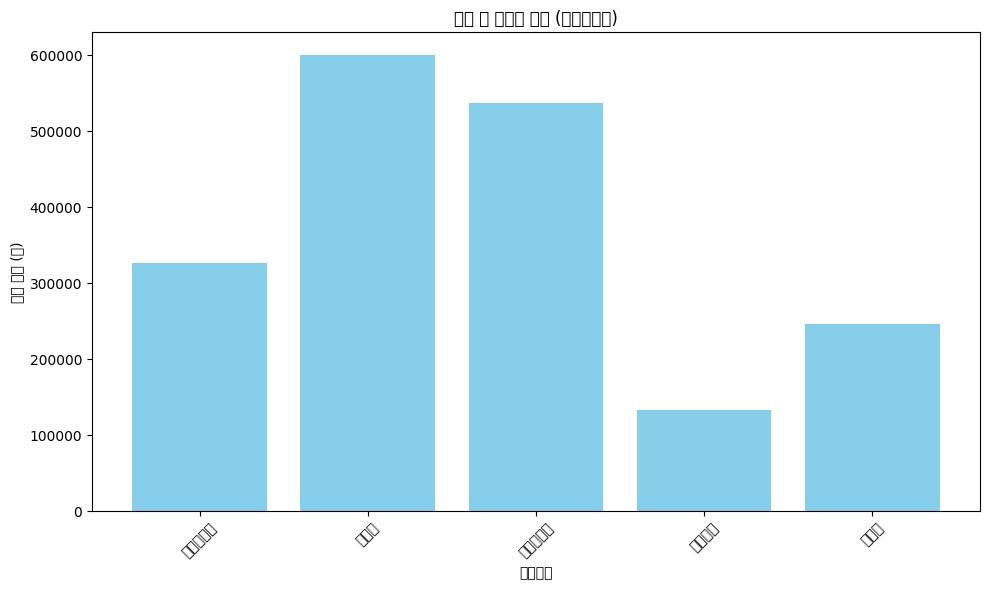

/Users/kimsomin/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


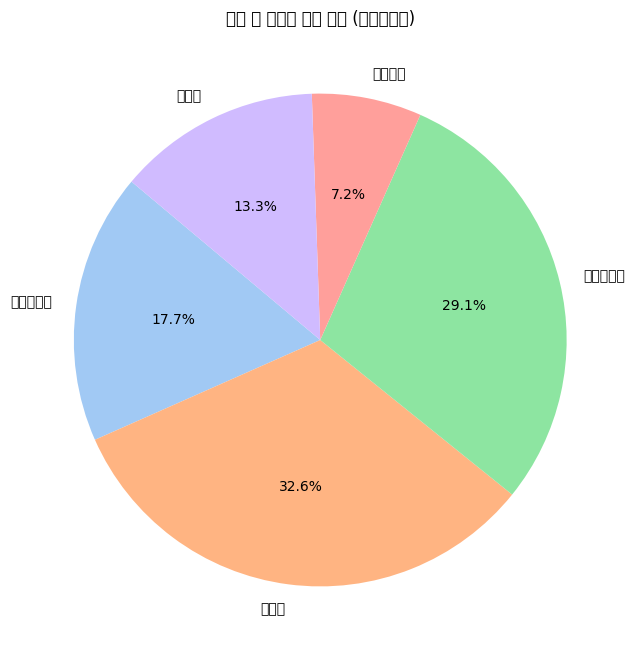

/Users/kimsomin/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.draw()
/Users/kimsomin/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  fig.canvas.draw()
/Users/kimsomin/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from current font.
  fig.canvas.draw()
/Users/kimsomin/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  fig.canvas.draw()
/Users/kimsomin/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.draw()
/Users/kimsomin/miniconda3/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}

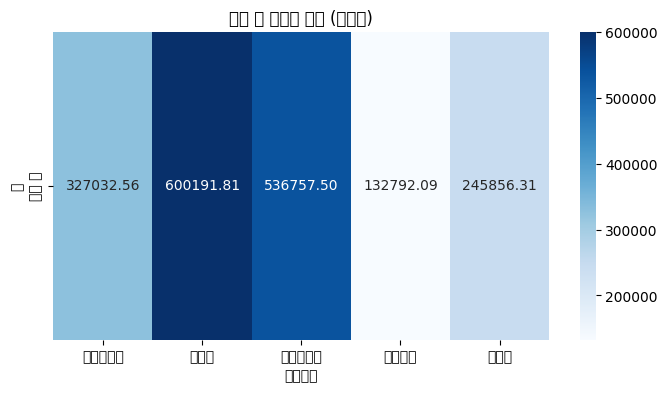

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# 예측 결과 데이터프레임으로 변환
predicted_df = pd.DataFrame(predicted_next_month, columns=account_categories)

# 1. 막대그래프
plt.figure(figsize=(10, 6))
plt.bar(account_categories, predicted_df.iloc[0], color='skyblue')
plt.title("다음 달 예측된 비용 (계정과목별)")
plt.ylabel("예측 금액 (원)")
plt.xlabel("계정과목")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. 원형 차트 (파이 차트)
plt.figure(figsize=(8, 8))
plt.pie(predicted_df.iloc[0], labels=account_categories, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("다음 달 예측된 비용 비율 (계정과목별)")
plt.show()

# 3. 히트맵
plt.figure(figsize=(8, 4))
sns.heatmap(predicted_df, annot=True, fmt=".2f", cmap="Blues", cbar=True, yticklabels=["다음 달"])
plt.title("다음 달 예측된 비용 (히트맵)")
plt.ylabel("월")
plt.xlabel("계정과목")
plt.show()


/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:22: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:22: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:22: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:22: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:22: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:22: UserWarnin

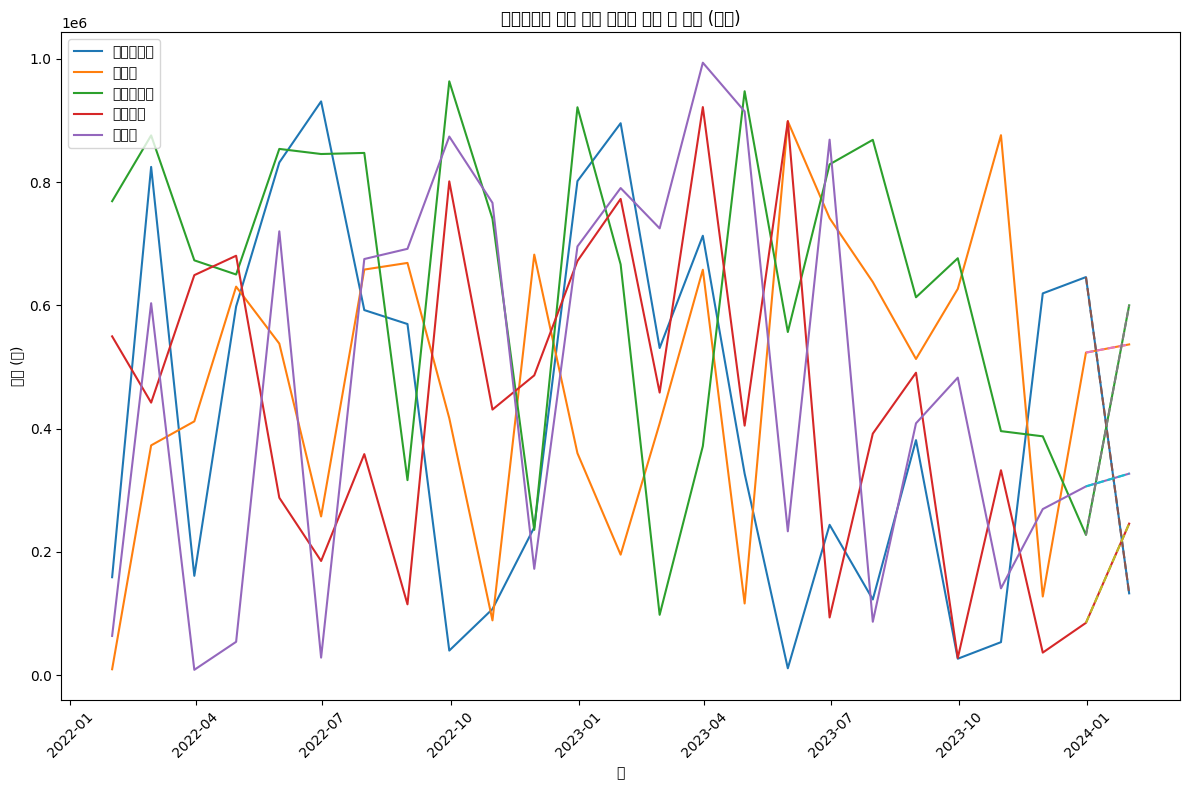

/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarnin

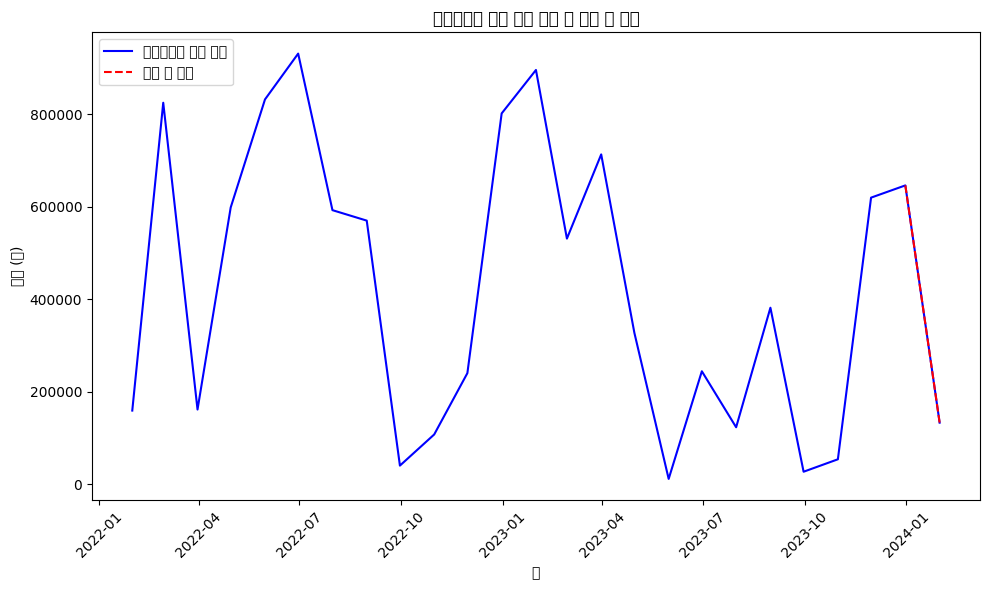

/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from current font.
  plt.tight_layout()


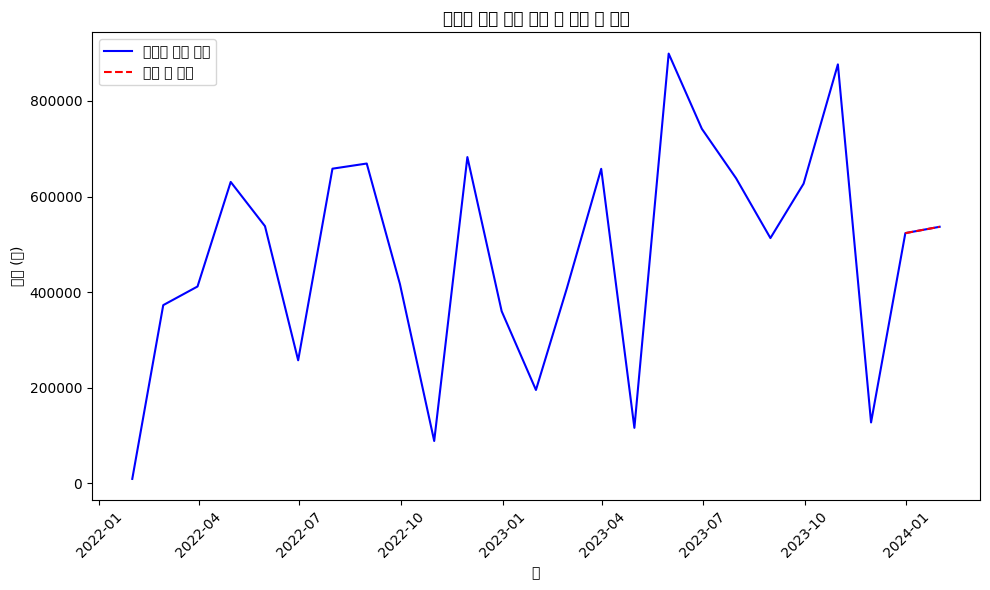

/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 50977 (\N{HANGUL SYLLABLE YUG}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from current font.
  plt.tight_layout()


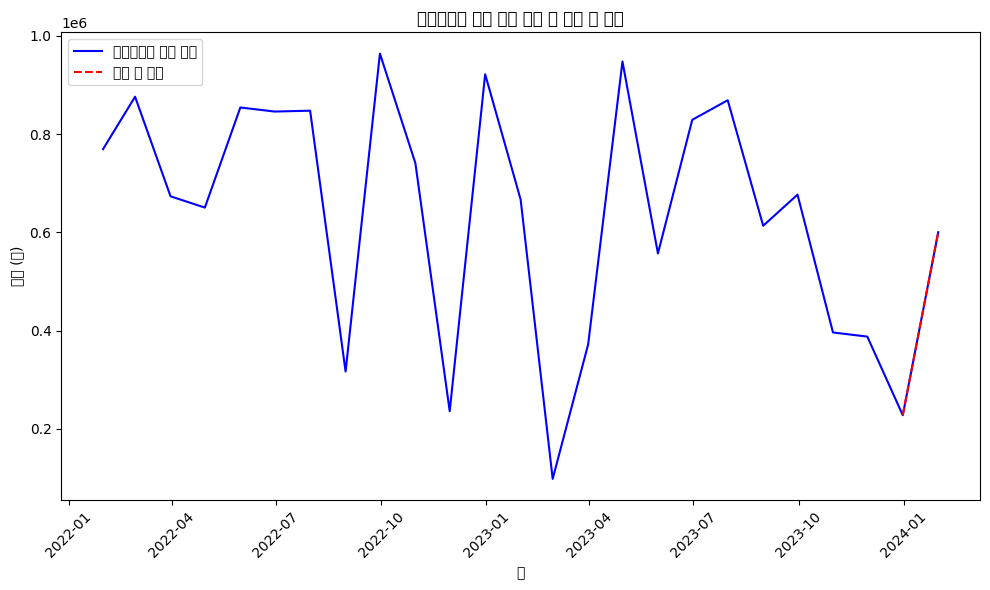

/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from current font.
  plt.tight_layout()
/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from current font.
  plt.tight_layout()


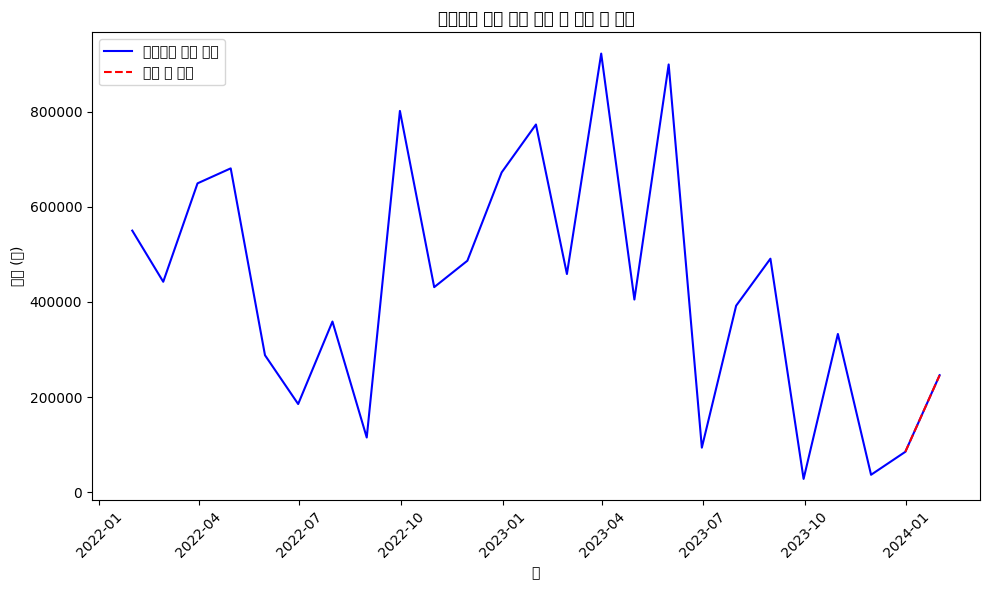

/var/folders/pw/w8rt727n6j51gnhj0dxq0xlw0000gn/T/ipykernel_73569/356853152.py:39: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from current font.
  plt.tight_layout()


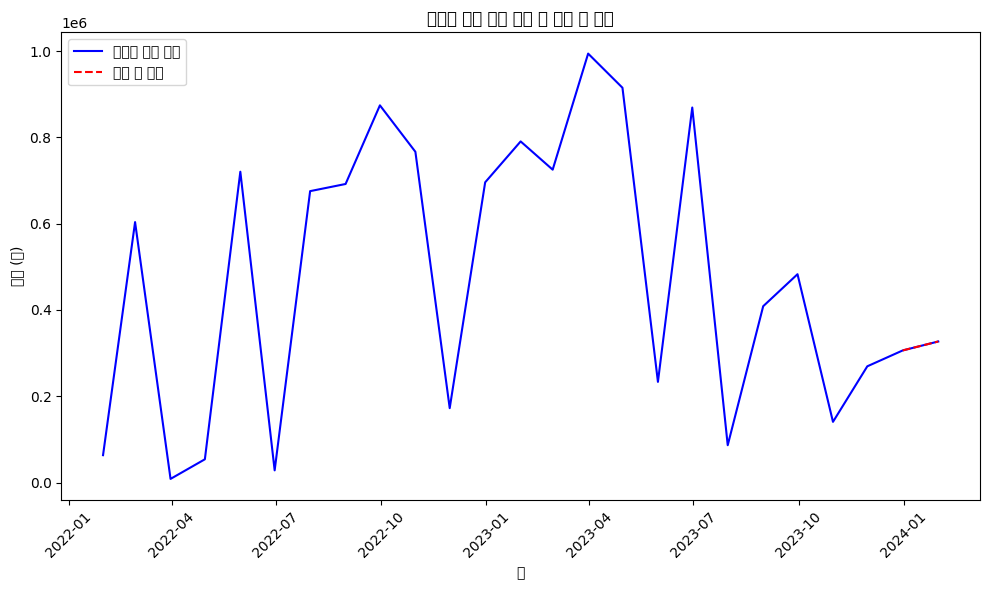

In [9]:
import matplotlib.pyplot as plt

# 기존 데이터에 다음 달 예측값 추가
df_pivot_with_prediction = df_pivot.copy()
df_pivot_with_prediction.loc[df_pivot.index[-1] + pd.DateOffset(months=1)] = predicted_next_month[0]

# 1. 전체 계정과목을 한 번에 표시하는 그래프
plt.figure(figsize=(12, 8))
for account in account_categories:
    plt.plot(df_pivot_with_prediction.index, df_pivot_with_prediction[account], label=account)

# 각 계정과목의 다음 달 예측값을 점선으로 표시
for account in account_categories:
    plt.plot(df_pivot_with_prediction.index[-2:], df_pivot_with_prediction[account].iloc[-2:], linestyle='--')

# 그래프 설정
plt.title("계정과목별 월별 비용 추이와 다음 달 예측 (전체)")
plt.xlabel("월")
plt.ylabel("금액 (원)")
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. 계정과목별 개별 그래프
for account in account_categories:
    plt.figure(figsize=(10, 6))
    plt.plot(df_pivot_with_prediction.index, df_pivot_with_prediction[account], label=f"{account} 비용 추이", color='blue')
    
    # 예측값을 점선으로 구분하여 표시
    plt.plot(df_pivot_with_prediction.index[-2:], df_pivot_with_prediction[account].iloc[-2:], linestyle='--', color='red', label="다음 달 예측")

    # 그래프 설정
    plt.title(f"{account} 월별 비용 추이 및 다음 달 예측")
    plt.xlabel("월")
    plt.ylabel("금액 (원)")
    plt.legend(loc="upper left")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
